<a href="https://colab.research.google.com/github/pnnowak/Projektyrynkifin/blob/roby/Modelowanieakcji_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import datetime as dt

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
sp500 = yf.download('^GSPC', start='2000-01-01', end='2025-01-01')

/tmp/ipython-input-3-2412655462.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start='2000-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


In [ ]:
close_prices = sp500['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler() # od 0 do 1
close_prices_scaled = scaler.fit_transform(close_prices)

In [ ]:
# Funkcja do tworzenia sekwencji
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, 0])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

dni_predycji = 60
X, y = create_sequences(close_prices_scaled, dni_predycji)
# X = X.reshape(-1, 1)
# y = y.reshape(-1, 1)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
model = Sequential([
    LSTM(50, input_shape=(60, 1), return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0063
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 4.2889e-05
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 3.4452e-05
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 3.3072e-05
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 3.1588e-05
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 2.9689e-05
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 3.1578e-05
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 3.0263e-05
Epoch 9/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 2.8143e-05
Epoch 10/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 2.7737e-05
Epoch 11/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 2.7961e-05
Epoch 12/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 2.7379e-05
Epoch 13/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 3.2522e-05
Epoch 14/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 2.

In [ ]:
predictions = model.predict(X_test)

# Odwrócenie skalowania
predictions = scaler.inverse_transform(predictions)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
print(predictions[:5])
print(y_test[:5])

[[3322.6753]
 [3325.273 ]
 [3324.593 ]
 [3325.09  ]
 [3307.9365]]
[0.48843498 0.4886123  0.48931238 0.48375798 0.47418233]


In [ ]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
print(y_test[:5])

[[3320.79003906]
 [3321.75      ]
 [3325.54003906]
 [3295.4699707 ]
 [3243.62988281]]


In [ ]:
# Obliczenie MSE
mse = mean_squared_error(y_test, predictions)
print(f"Błąd średniokwadratowy (MSE): {mse:.2e}")

Błąd średniokwadratowy (MSE): 2.72e+03


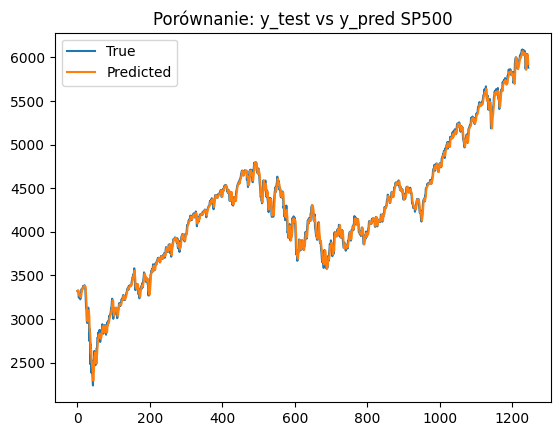

In [ ]:
plt.plot(y_test, label='True')
plt.plot(predictions, label='Predicted')
plt.title("Porównanie: y_test vs y_pred SP500")
plt.legend()
plt.show()

## Bardziej zaawansowany model

In [ ]:
#drugi model trochę większy
model1 = Sequential()

model1.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model1.add(Dropout(0.2))
model1.add(LSTM(units=50, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(units=50))
model1.add(Dropout(0.2))
model1.add(Dense(units=1))

model1.compile(optimizer='adam', loss='mse')
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history1 = model1.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - loss: 3.4489e-04
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - loss: 2.9154e-04
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 23s 102ms/step - loss: 2.7773e-04
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - loss: 3.1940e-04
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - loss: 2.2384e-04
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - loss: 2.1201e-04
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 2.1915e-04
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - loss: 1.9067e-04
Epoch 9/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 1.8950e-04
Epoch 10/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 1.7190e-04
Epoch 11/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - loss: 1.7409e-04
Epoch 12/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - loss: 1.7439e-04
Epoch 13/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 1.4809e-04
Epoch 14/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 

In [ ]:
predictions1 = model1.predict(X_test)

# Odwrócenie skalowania
predictions1 = scaler.inverse_transform(predictions1)

print("Przykładowe predykcje po odwróceniu skalowania:", predictions1[:5])

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Przykładowe predykcje po odwróceniu skalowania: [[3252.0154]
 [3260.8503]
 [3269.012 ]
 [3276.149 ]
 [3280.495 ]]


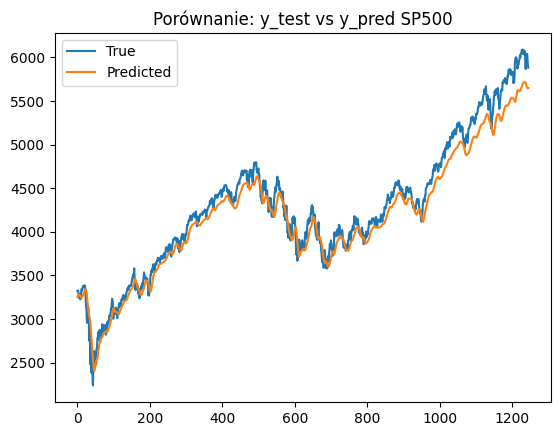

In [ ]:
plt.plot(y_test, label='True')
plt.plot(predictions1, label='Predicted')
plt.title("Porównanie: y_test vs y_pred SP500")
plt.legend()
plt.show()

In [ ]:
# Obliczenie MSE
mse1 = mean_squared_error(y_test, predictions1)
print(f"Błąd średniokwadratowy (MSE): {mse1:.2e}")

Błąd średniokwadratowy (MSE): 2.58e+04


## Porównanie z bardzo prostymi modelami

In [ ]:
baseline_predictions = np.full_like(y_test, np.mean(y_train))

# Obliczenie błędu średniokwadratowego (MSE) dla modelu referencyjnego
baseline_mse = mean_squared_error(y_test, baseline_predictions)
print(f"Błąd średniokwadratowy modelu referencyjnego (MSE): {baseline_mse:.2e}")

Błąd średniokwadratowy modelu referencyjnego (MSE): 1.88e+07


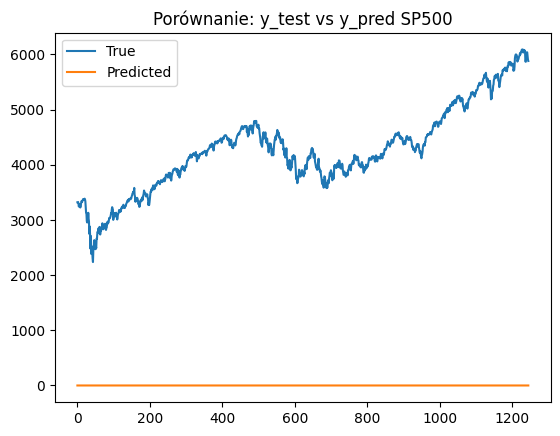

In [ ]:
plt.plot(y_test, label='True')
plt.plot(baseline_predictions, label='Predicted')
plt.title("Porównanie: y_test vs y_pred SP500")
plt.legend()
plt.show()

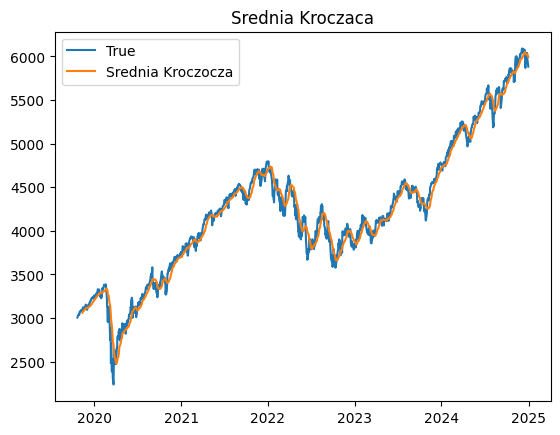

Błąd średniokwadratowy modelu referencyjnego (MSE): 9.88e+03


In [ ]:
# Tworzymy nowy DataFrame do obliczeń średniej kroczącej
sp5001 = pd.DataFrame()
split = int(len(y) * 0.8)  # Podział na zbiór treningowy i testowy
sp5001['Test'] = sp500["Close"][split:]  # Dane treningowe (pierwsze 80%)

# Obliczanie średniej kroczącej (SMA) z 16 dni
window_size = 16
sp5001['SMA'] = sp5001['Test'].rolling(window=window_size).mean()

plt.plot(sp5001['Test'], label='True')
plt.plot(sp5001['SMA'] , label='Srednia Kroczocza')
plt.title("Srednia Kroczaca")
plt.legend()
plt.show()

# Usunięcie wierszy z NaN przed obliczeniem MSE
sp5001_cleaned = sp5001.dropna()

srednia_kroczaca = mean_squared_error(sp5001_cleaned['Test'], sp5001_cleaned['SMA'])
print(f"Błąd średniokwadratowy modelu referencyjnego (MSE): {srednia_kroczaca:.2e}")

### Zapisywanie, wczytywanie i wyświetlanie wykresów pierwszego Modelu.




In [ ]:
from google.colab import drive
from google.colab import files

# Zapisz model lokalnie w katalogu Colab
model.save('lstm_model.keras')
files.download('lstm_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving lstm_model.keras to lstm_model.keras


In [ ]:
# Wczytanie modelu z Google Drive
from tensorflow.keras.models import load_model
model = load_model("lstm_model.keras")

# Sprawdzenie struktury modelu
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

In [ ]:
history.history.keys()

dict_keys(['loss'])

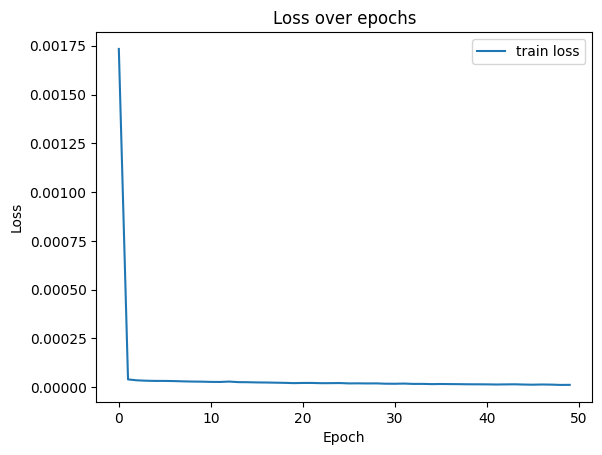

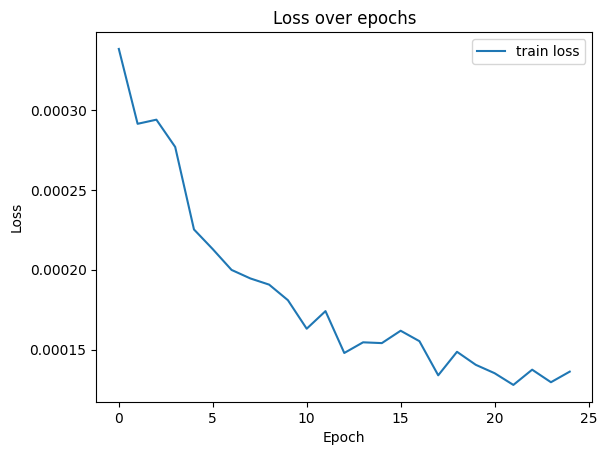

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history1.history['loss'], label='train loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

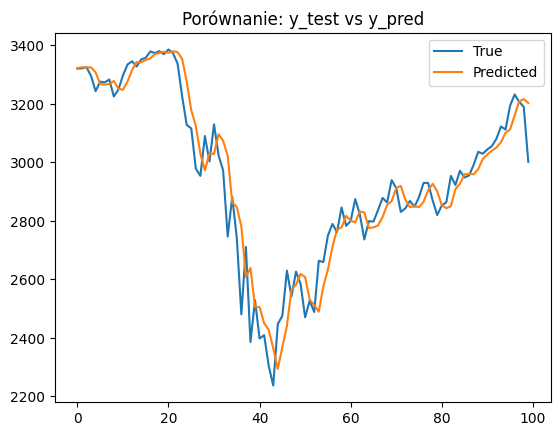

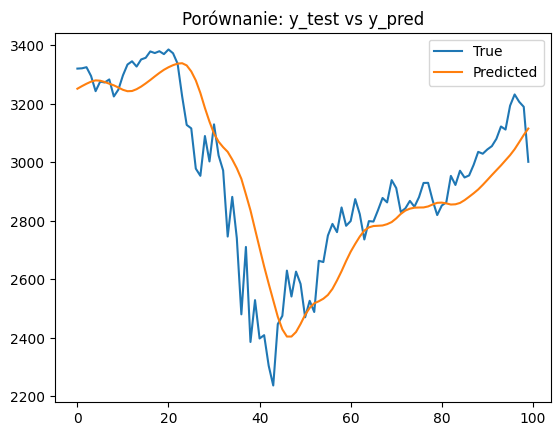

In [ ]:
plt.plot(y_test[:100], label='True')
plt.plot(predictions[:100], label='Predicted')
plt.title("Porównanie: y_test vs y_pred")
plt.legend()
plt.show()

plt.plot(y_test[:100], label='True')
plt.plot(predictions1[:100], label='Predicted')
plt.title("Porównanie: y_test vs y_pred")
plt.legend()
plt.show()